In [33]:
import pandas as pd
import glob
from scipy.signal import butter, filtfilt
import os


# Laod Files

In [34]:
files = glob.glob("./tlvmc-parkinsons-freezing-gait-prediction/train/defog/*.csv")

## Load Metadata

In [35]:
meta = pd.read_csv("./tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv")

In [36]:
all_labels = []
all_subjects = []

for f in files:

    # Load sensor file
    df = pd.read_csv(f)

    # Extract Id from filename
    file_id = os.path.basename(f).replace(".csv","")

    df["Id"] = file_id

    # --- Add metadata ---
    info = meta[meta["Id"] == file_id].iloc[0]
    df["Subject"] = info["Subject"]
    df["Visit"] = info["Visit"]
    df["Medication"] = info["Medication"]

## Converting g -> m/s^2

In [37]:
G = 9.80665
df["AccV"]  = df["AccV"]  * G
df["AccML"] = df["AccML"] * G
df["AccAP"] = df["AccAP"] * G

## Filter the signal ( Butterworth Low-Pass Filter)

In [38]:
def butter_lowpass_filter(data, cutoff=5, fs=100, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

Fs = 100   # change if needed

for col in ["AccV", "AccML", "AccAP"]:
    df[col] = butter_lowpass_filter(df[col], cutoff=5, fs=Fs)

## Z- Score Normalization

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df[["AccV","AccML","AccAP"]] = scaler.fit_transform(
    df[["AccV","AccML","AccAP"]]
)


## Build the fog Label

In [40]:
 df["FOG"] = (
        (df["StartHesitation"] == 1) |
        (df["Turn"] == 1) |
        (df["Walking"] == 1)
    ).astype(int)

## Sliding Windows

In [44]:
all_windows = []
all_labels = []
all_subjects = []

window_size = 200
stride = 50

for start in range(0, len(df) - window_size, stride):
    end = start + window_size
    w = df.iloc[start:end]

    X = w[["AccV", "AccML", "AccAP"]].values
    y = int(w["FOG"].max())   # Label: 1 if any FOG in window else 0

    all_windows.append(X)
    all_labels.append(y)
    all_subjects.append(df["Subject"].iloc[0])


In [46]:
import numpy as np
X = np.array(all_windows)
y = np.array(all_labels)
subjects = np.array(all_subjects)

## Only Useful Rows

In [47]:
df = df[(df["Valid"] == 1) & (df["Task"] == 1)]

In [48]:
df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,Id,Subject,Visit,Medication,FOG
1000,1000,0.263899,-0.562115,0.005945,0,0,0,True,True,f9fc61ce85,040587,1,on,0
1001,1001,0.339524,-0.629187,0.000056,0,0,0,True,True,f9fc61ce85,040587,1,on,0
1002,1002,0.408635,-0.709533,0.001582,0,0,0,True,True,f9fc61ce85,040587,1,on,0
1003,1003,0.461828,-0.799000,0.011787,0,0,0,True,True,f9fc61ce85,040587,1,on,0
1004,1004,0.488179,-0.891855,0.031397,0,0,0,True,True,f9fc61ce85,040587,1,on,0


# Visulization

## Conversion of Unit g -> m/s^2

## Plot acceleration with FOG highlighted


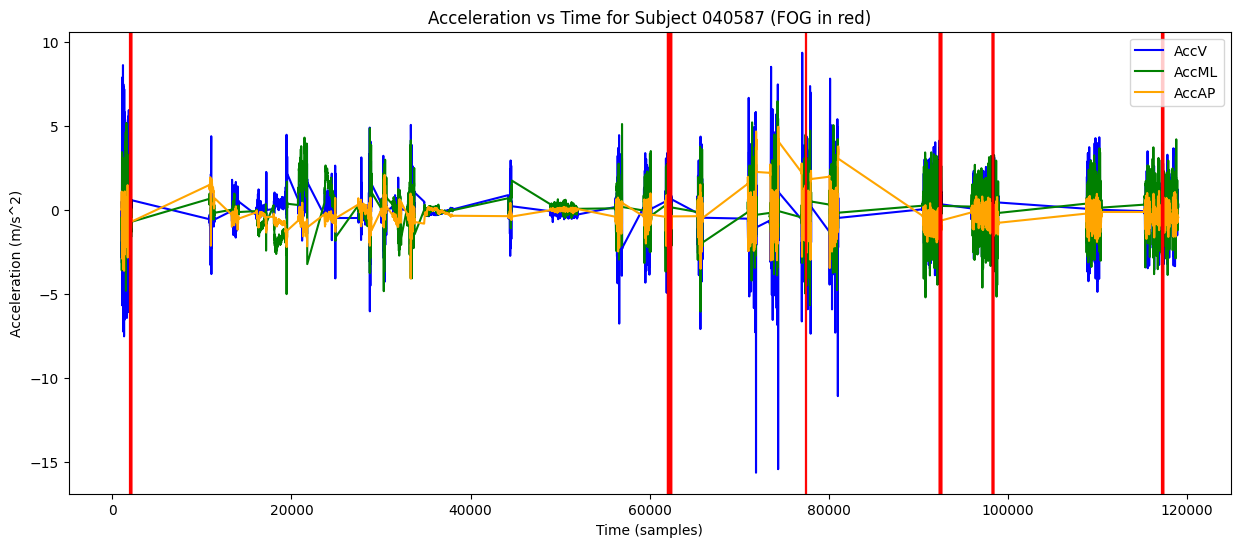

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(df["Time"], df["AccV"], label="AccV", color='blue')
plt.plot(df["Time"], df["AccML"], label="AccML", color='green')
plt.plot(df["Time"], df["AccAP"], label="AccAP", color='orange')

# Highlight FOG periods
fog_times = df[df["FOG"]==1]["Time"]
for t in fog_times:
    plt.axvline(x=t, color='red', alpha=0.2)

plt.title(f"Acceleration vs Time for Subject {df['Subject'].iloc[0]} (FOG in red)")
plt.xlabel("Time (samples)")
plt.ylabel("Acceleration (m/s^2)")
plt.legend()
plt.show()

In above Red vertical lines = timestamps where FOG=1, You can see how acceleration patterns differ during FOG vs normal walking, Blue/Green/Orange lines = vertical, mediolateral, anteroposterior acceleration

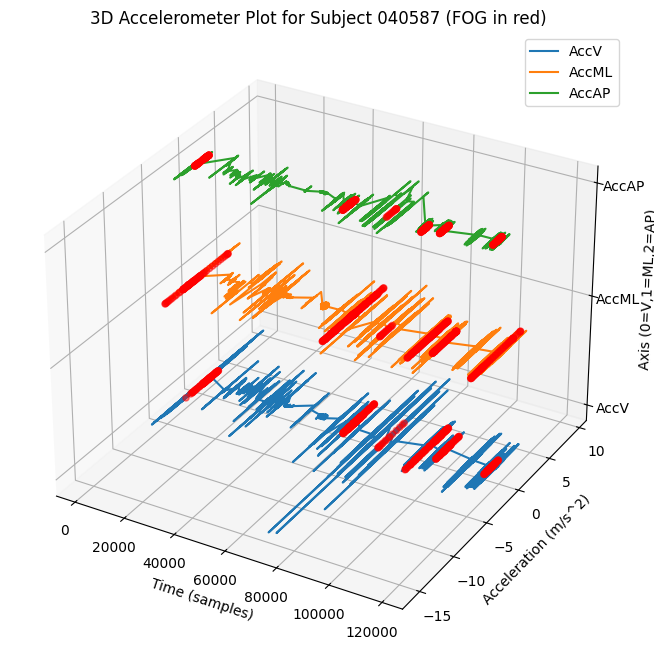

In [50]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')

# Map axis labels to integers for Z
axis_map = {"AccV":0, "AccML":1, "AccAP":2}

for axis in ["AccV","AccML","AccAP"]:
    z = np.full(len(df), axis_map[axis])
    ax.plot(df["Time"], df[axis], z, label=axis)

# Highlight FOG points
fog_points = df[df["FOG"]==1]["Time"]
for t in fog_points:
    ax.scatter([t]*3, df.loc[df["Time"]==t, ["AccV","AccML","AccAP"]].values[0], [0,1,2], color='red', alpha=0.5)

ax.set_xlabel("Time (samples)")
ax.set_ylabel("Acceleration (m/s^2)")
ax.set_zlabel("Axis (0=V,1=ML,2=AP)")
ax.set_zticks([0,1,2])
ax.set_zticklabels(["AccV","AccML","AccAP"])
ax.set_title(f"3D Accelerometer Plot for Subject {df['Subject'].iloc[0]} (FOG in red)")
ax.legend()
plt.show()
